In [1]:
import healpy as hp
import numpy as np
import math
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
%matplotlib inline
from matplotlib import colors
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [2]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [49]:
ffem = hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', field=1)
ffT = hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', field=4)
h = hp.read_map('mom0_-90_90_1024.hpx.fits')                                    #reads map of HI column denisty
N_HI = hp.pixelfunc.ud_grade(h, 256)                                              #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')                                       #reads map of CNM fraction
f_CNM = change_coord(CNM, 'CG')
fCNM = hp.ud_grade(f_CNM, 256)                                                   #degrades to NPIX = 256
Ad = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=0)
Td = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=1)
Bd = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=2)

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


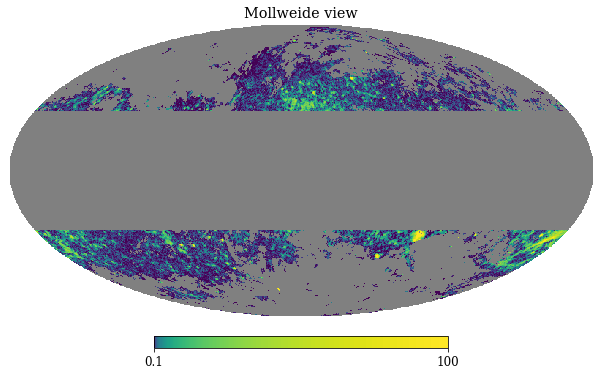

In [50]:
idx = np.where((np.isfinite(fCNM)) & (fCNM > 0.02))
mask = np.zeros_like(fCNM)
mask[idx] = 1

ffem[mask == 0] = 0
ffT[mask == 0] = 0
fCNM[mask == 0] = 0
N_HI[mask == 0] = 0
Ad[mask == 0] = 0
Td[mask == 0] = 0
Bd[mask == 0] = 0

hp.mollview(ffem, min=.1, max=100, norm='log')

In [96]:
def I_free(EM, T, nu):
    T4 = T/(10^4)
    nu9 = nu/(10^9)
    
    smalllog = nu9*T4**(-3/2)
    exp1 = 5.960 - (np.sqrt(3)/np.pi)*np.log10(smalllog)
    biglog = np.exp(exp1) + np.exp(1)
    gff = np.log10(biglog)
    tau = 0.05468*T**(-3/2)*nu9**(-2)*EM*gff
    
    sff = (10**6)*T*(1-np.exp(-tau))
    sKrj = sff*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr)
    sMjy = sKrj.to(cds.MJy/cds.sr)
    
    return sMjy * (cds.sr/cds.MJy)

In [91]:
def I_therm(A_d, B_d, T_d, nu):
    
    gamma = const.h/(const.k_B*T_d)
    gam = gamma.value
    frac1 = nu/(545)
    frac2 = (np.exp(gam*545)-1)/(np.exp(gam*nu)-1)
    Beta = B_d + 1
    
    S_td = A_d*(frac1**Beta)*frac2
    I_td = S_td*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr)
    I_thermdust = I_td.to(cds.MJy/cds.sr)
    
    return I_thermdust * cds.sr/cds.MJy

I_td = I_therm(Ad,Bd,Td,545)

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1121: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1122: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


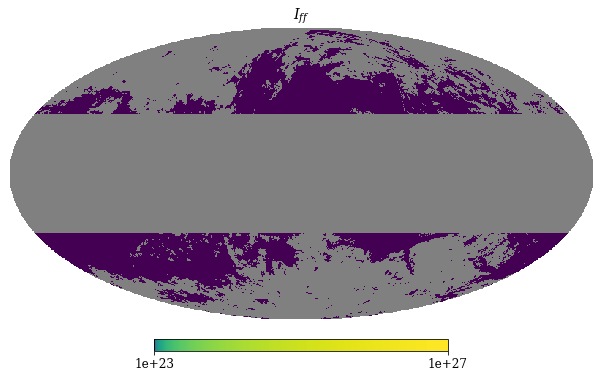

In [121]:
ff_1GHz = I_free(ffem, ffT, 1)
hp.mollview(ff_1GHz, title=r'$I_{ff}$',min=1e23, max=1e27, norm='log')

In [108]:
# Finds frequency at which we see the average I for each pixel
fCNM_short = fCNM[idx]

nu = np.linspace(0, 1000, 500)
I_nustack = np.zeros((len(nu), len(ffem)))
I_unnorm = np.zeros((len(nu), len(ffem)))
for i, freq in enumerate(nu):
    I_nu = I_free(ffem, ffT, freq)
    I_unnorm[i,:] = I_nu
    
    I_normalize = I_nu/I_td
    I_nustack[i,:] = I_normalize

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [109]:
nu_flat = np.reshape(nu, (500,1))
integrand = nu_flat*I_unnorm

Integ1 = integrate.simps(integrand.T)
Integ2 = integrate.simps(I_nustack.T)
Integ3 = integrate.simps(I_unnorm.T)
nu_avg = Integ1/Integ2
integ = Integ3/N_HI

integ_short = integ[idx]
nuavg_short = nu_avg[idx]

numbins = 150
nuavg_means, nuavg_edges, nuavg_num = stats.binned_statistic(fCNM_short, nuavg_short, statistic='median', bins=numbins, range=[0.02, .36])
integ_means, integ_edges, integ_num = stats.binned_statistic(fCNM_short, integ_short, statistic='median', bins=numbins, range=[0.02, .36])

/home/mdodici/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1114: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))
/home/mdodici/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1114: RuntimeWarning: divide by zero encountered in true_divide
  resdat /= (np.log(vmax) - np.log(vmin))


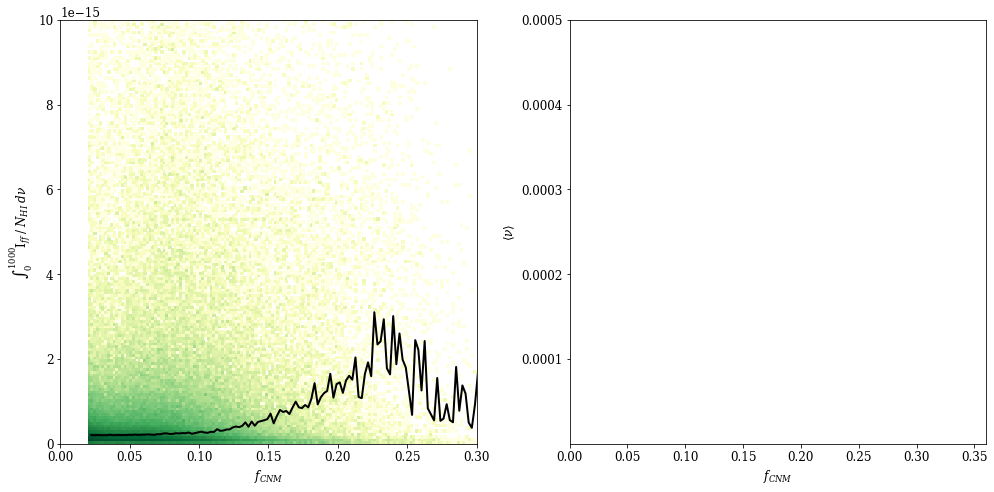

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
#fig.text(0.518, 1, r'$\langle \nu \rangle\: vs.\: f_{CNM}$', ha='center')

ax[1].hist2d(fCNM_short, nuavg_short, bins=100,range=[[0, .36], [0.000000001, .0005]], cmap='YlGn', norm=colors.LogNorm(.9))
ax[1].plot(nuavg_edges[1:], nuavg_means, 'k', lw=2)
#ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\langle \nu \rangle$')
ax[1].set_xlabel(r'$f_{CNM}$')

ax[0].hist2d(fCNM_short, integ_short, bins=150,range=[[0, .30], [0, 1e-14]], cmap='YlGn', norm=colors.LogNorm(.9))
ax[0].plot(integ_edges[1:], integ_means, 'k', lw=2)
ax[0].set_ylim(0,1e-14)
#ax[0].set_yscale('log')
ax[0].set_xlabel(r'$f_{CNM}$')
ax[0].set_ylabel(r'$\int_0^{1000} \mathrm{I}_{ff}\:/\:N_{HI}\:d\nu$')

#ax[1].scatter(fCNM_short, nuavg_short, s=1, alpha=.3)
#ax[1].set_xlim(0, .36)
#ax[1].set_ylim(20, 40)
#ax[1].set_xlabel(r'$f_{CNM}$')

fig.tight_layout()

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


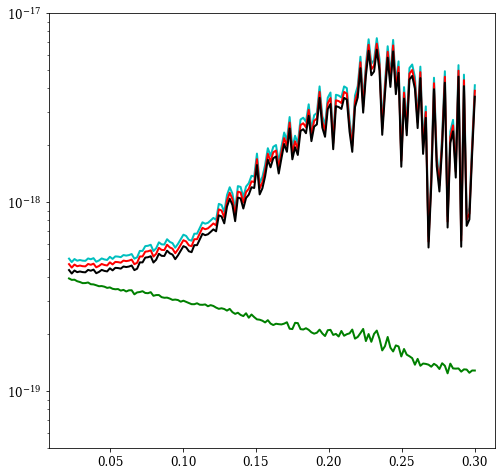

In [126]:
GHz_001_short = (I_free(ffem,ffT,.001)/N_HI)[idx]
GHz1_short = (ff_1GHz/N_HI)[idx]
GHz10_short = (I_free(ffem,ffT,10)/N_HI)[idx]
GHz100_short = (I_free(ffem,ffT,100)/N_HI)[idx]

GHz001_meds, GHz001_edges, GHz001_num = stats.binned_statistic(fCNM_short, GHz_001_short, statistic='median', bins=150, range=[0.02, .30])
GHz_meds, GHz_edges, GHz_num = stats.binned_statistic(fCNM_short, GHz1_short, statistic='median', bins=150, range=[0.02, .30])
GHz10_meds, GHz10_edges, GHz10_num = stats.binned_statistic(fCNM_short, GHz10_short, statistic='median', bins=150, range=[0.02, .30])
GHz100_meds, GHz100_edges, GHz100_num = stats.binned_statistic(fCNM_short, GHz100_short, statistic='median', bins=150, range=[0.02, .30])

fig, ax = plt.subplots(figsize=(8,8))

#ax.scatter(fCNM_short, GHz_001_short, c='g', s=1, alpha=.3)
#ax.scatter(fCNM_short, GHz1_short, c='b', s=1, alpha=.3)
#ax.scatter(fCNM_short, GHz10_short, c='r', s=1, alpha=.3)
#ax.scatter(fCNM_short, GHz100_short, c='y', s=1, alpha=.3)
ax.plot(GHz001_edges[1:], GHz001_meds, 'g', lw=2)
ax.plot(GHz_edges[1:], GHz_meds, 'c', lw=2)
ax.plot(GHz10_edges[1:], GHz10_meds, 'r', lw=2)
ax.plot(GHz100_edges[1:], GHz100_meds, 'k', lw=2)
ax.set_ylim(5e-20,1e-17)
ax.set_yscale('log')

In [83]:
def plot_binper(frequencies, med, per84, per16, col, axnum):
    median_line, = axnum.plot(frequencies, med, color=col)
    #axnum.fill_between(frequencies, per84, per16, color=col, alpha=.5)
    #axnum.plot(frequencies, per84, color=col, linestyle=':', alpha=.6)
    #axnum.plot(frequencies, per16, color=col, linestyle=':', alpha=.6)
    return median_line

/home/mdodici/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


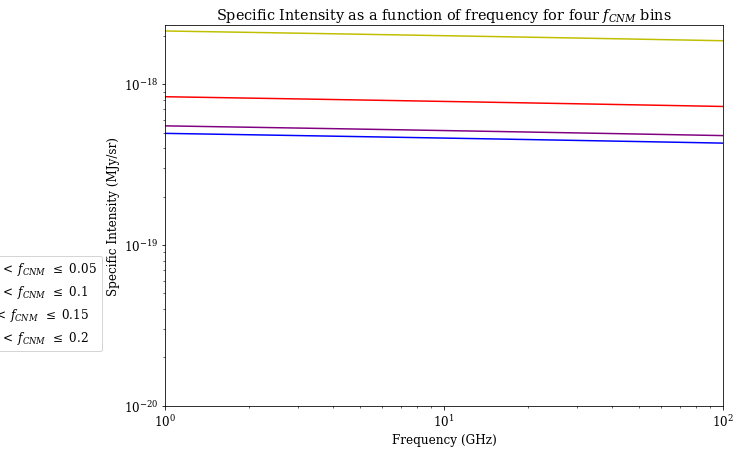

In [118]:
nu_small = np.linspace(1, 100, 100)

Im0, Im1, Im2, Im3 = (np.zeros(len(nu_small)) for i in range(4))
Is0, Is1, Is2, Is3 = (np.zeros(len(nu_small)) for i in range(4)) 
Ip0, Ip1, Ip2, Ip3 = (np.zeros((len(nu_small), 2)) for i in range(4))

low0, low1, low2, low3 = 0.02, 0.05, 0.10, 0.15
high0, high1, high2, high3 = 0.05, 0.10, 0.15, 0.20

I_normto = I_therm(Ad, Bd, Td, 545)

for i, freq in enumerate(nu_small):                               
    I_nu = I_free(ffem, ffT, freq)                        
    I_normalize = I_nu/N_HI

    Im0[i] = np.median(I_normalize[(fCNM > low0) & (fCNM <= high0)])
    Im1[i] = np.median(I_normalize[(fCNM > low1) & (fCNM <= high1)])
    Im2[i] = np.median(I_normalize[(fCNM > low2) & (fCNM <= high2)])
    Im3[i] = np.median(I_normalize[(fCNM > low3) & (fCNM <= high3)])
    
    Ip0[i,:] = np.percentile(I_normalize[(fCNM > low0) & (fCNM <= high0)], (16, 84))
    Ip1[i,:] = np.percentile(I_normalize[(fCNM > low1) & (fCNM <= high1)], (16, 84))
    Ip2[i,:] = np.percentile(I_normalize[(fCNM > low2) & (fCNM <= high2)], (16, 84))
    Ip3[i,:] = np.percentile(I_normalize[(fCNM > low3) & (fCNM <= high3)], (16, 84))

binfig, binax = plt.subplots(figsize=(10,7))

med3 = plot_binper(nu_small, Im3, Ip3[:,0], Ip3[:,1], 'y', binax)
med2 = plot_binper(nu_small, Im2, Ip2[:,0], Ip2[:,1], 'red', binax)
med1 = plot_binper(nu_small, Im1, Ip1[:,0], Ip1[:,1], 'purple', binax)
med0 = plot_binper(nu_small, Im0, Ip0[:,0], Ip0[:,1], 'blue', binax)
csigma = Line2D([0], [0], color='k', linewidth=3, linestyle=':')

label0 = f"{low0} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high0}"
label1 = f"{low1} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high1}"
label2 = f"{low2} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high2}"
label3 = f"{low3} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high3}" 
lsigma = 'represents ' + r'$\:\pm\:1\:\sigma$'

binax.set_xscale('log')
binax.set_yscale('log')
binax.set_xlim(1,100)
binax.set_ylim(1e-20,)
binax.set_title('Specific Intensity as a function of frequency for four ' + r'$f_{CNM}$' + ' bins')
binax.set_xlabel('Frequency (GHz)')
binax.set_ylabel('Specific Intensity (MJy/sr)')

plt.figlegend(handles=[med0, med1, med2, med3], labels=[label0, label1, label2, label3], 
              loc='lower right', bbox_to_anchor=(0.15, 0.19))